In [1]:
import torch
import gpytorch
import numpy as np
from scipy.stats import norm
from scipy.spatial import distance

import matplotlib
import matplotlib.pyplot as plt

from gpytorch.priors import NormalPrior

from tqdm.notebook import tqdm

# Dumbbell

## Sampling and Helper Functions

### Sampling from a Dumbbell

In [2]:
def create_dumbbell(circle_center_x, rec_long_side, rec_short_side):
    diff_x = circle_center_x - (rec_long_side/2)
    assert diff_x > 0
    
    circle_radius = distance.euclidean([circle_center_x,0], [rec_long_side/2,rec_short_side/2])
    
    angle = np.arccos((circle_center_x - rec_long_side/2.0)/circle_radius)
    add_angle = 1/(100*circle_radius)
    circle_perimeter = 4 * (np.pi - angle) * circle_radius
    rec_perimeter = 2 * rec_long_side
    total_perimeter = circle_perimeter + rec_perimeter
    
    samples = torch.empty((int(100 * total_perimeter), 2), dtype=torch.float32)
    samples_till_now = 0
    rec_sample = int(rec_perimeter * 50)
    circle_sample = int(circle_perimeter * 50)
    
    for i in range(rec_sample):
        samples[i] = torch.Tensor([-rec_long_side/2 + i/100.0, rec_short_side/2])
    samples_till_now+=rec_sample
    
    starting_angle = np.pi - angle
    for j in range(circle_sample):
        new_angle = starting_angle - j*add_angle
        samples[samples_till_now+j] = torch.Tensor([circle_center_x+circle_radius*np.cos(new_angle), circle_radius*np.sin(new_angle)])
    samples_till_now+=circle_sample
    
    for i in range(rec_sample):
        samples[samples_till_now+i] = torch.Tensor([rec_long_side/2 - i/100.0, -rec_short_side/2])
    samples_till_now+=rec_sample
    
    starting_angle = angle
    for j in range(circle_sample):
        new_angle = starting_angle + j*add_angle
        samples[samples_till_now+j] = torch.Tensor([-circle_center_x+circle_radius*np.cos(new_angle), circle_radius*np.sin(new_angle)])
    samples_till_now+=circle_sample
    
    return samples[0:samples_till_now]


### Creating a Grid around Samples

In [3]:
def create_grid(sampled, eps=0.1, res=0.01):
    dims = len(sampled.shape)
    
    borders = torch.empty((dims, 2), dtype=torch.float32)
    for i in range(dims):
        borders[i, 0] = min(sampled[:,i]) - eps
        borders[i, 1] = max(sampled[:,i]) + eps
        
    grid_sizes = torch.empty(dims, dtype=torch.int32)
    for i in range(dims):
        grid_sizes[i] = (borders[i, 1] - borders[i, 0])/res + 1
        
    grid_points = torch.empty((torch.prod(grid_sizes).int(), 2), dtype=torch.float32)
    if (dims==2):
        for x in range(grid_sizes[0]):
            for y in range(grid_sizes[1]):
                index = (x * grid_sizes[1]) + y
                grid_points[index] = torch.Tensor([borders[0, 0] + x * res, borders[1, 0] + y * res])
    return grid_points, grid_sizes


### Computing Unsigned Distance

In [4]:
def distance_from_circle(circle_center, circle_radius, pt):
    return distance.euclidean(pt, circle_center)-circle_radius
    
def udf_dumbbell_pt(circle_center_x, rec_long_side, rec_short_side, pt):
    diff_x = circle_center_x - (rec_long_side/2)
    assert diff_x > 0
    
    circle_radius = distance.euclidean([circle_center_x,0], [rec_long_side/2,rec_short_side/2])
    circle_center = np.array([circle_center_x, 0])
    x, y = pt

    if -rec_long_side/2 <= x <= rec_long_side/2:
        if -rec_short_side/2 <= y <= rec_short_side/2:
            return min(torch.abs(rec_short_side/2 -y), torch.abs(y+rec_short_side/2))
        else:
            if x < 0:
                circle_center = -circle_center
            if y >= rec_short_side/2:
                return min(y-rec_short_side/2, distance_from_circle(circle_center, circle_radius, pt))
            else:
                return min(-y-rec_short_side/2, distance_from_circle(circle_center, circle_radius, pt))    
    else:
        if x < 0:
                circle_center = -circle_center
        return np.abs(distance_from_circle(circle_center, circle_radius, pt))

def udfs_from_dumbbell(circle_center_x, rec_long_side, rec_short_side, points):
    udf_pts = torch.empty(points.size()[0], dtype=torch.float32)
    for i in range(udf_pts.size()[0]):
        udf_pts[i] = udf_dumbbell_pt(circle_center_x, rec_long_side, rec_short_side, points[i])
    return udf_pts


### Getting Basic Plots

In [5]:
def get_sample_plot(samples):
    with torch.no_grad():
        fig = plt.figure(figsize=(11, 4))
        ax = fig.add_subplot(111)
        plot = ax.scatter(samples.cpu().numpy()[:, 0], samples.cpu().numpy()[:, 1], s = 0.1)
        ax.axis('equal')
        ax.set_title(f'Samples on the Surface')
        
def get_udf_plot(grid_points, udfs_grid):
    with torch.no_grad():
        fig = plt.figure(figsize=(11, 4))
        ax = fig.add_subplot(111)
        plot = ax.scatter(grid_points.cpu().numpy()[:, 0], grid_points.cpu().numpy()[:, 1], c=udfs_grid.cpu().numpy(),s = 0.1)
        fig.colorbar(plot)
        ax.axis('equal')
        ax.legend_ = None
        ax.set_title(f'Grid Points with UDF')
        
def get_plots(samples, grid_points, udf, plot_samples=True, plot_udf=True):
    if plot_samples:
        get_sample_plot(samples)
    if plot_udf:
        get_udf_plot(grid_points, udf)
        

### Putting All Together

In [6]:
def initiate_dumbbell(circle_center_x, rec_long_side, rec_short_side, plot_samples=True, plot_udf=True):
    dumbbell_samples = create_dumbbell(circle_center_x, rec_long_side, rec_short_side)
    grid_points, grid_sizes = create_grid(dumbbell_samples)
    grid_udfs = udfs_from_dumbbell(circle_center_x, rec_long_side, rec_short_side, grid_points)
    get_plots(dumbbell_samples, grid_points, grid_udfs, plot_samples, plot_udf)
    return dumbbell_samples, grid_points, grid_udfs, grid_sizes
    

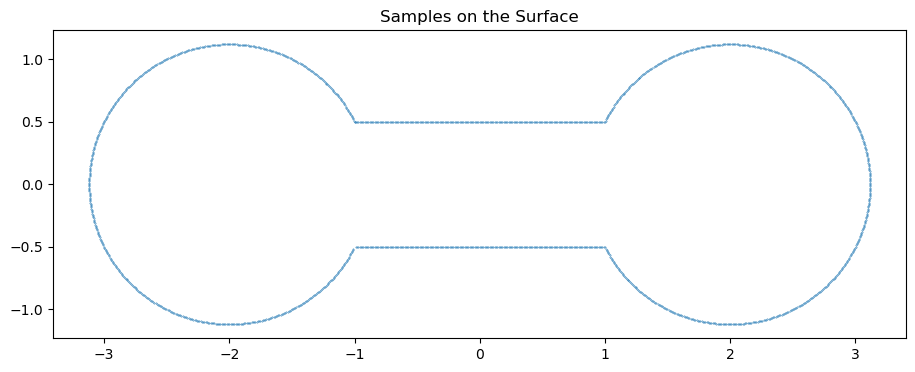

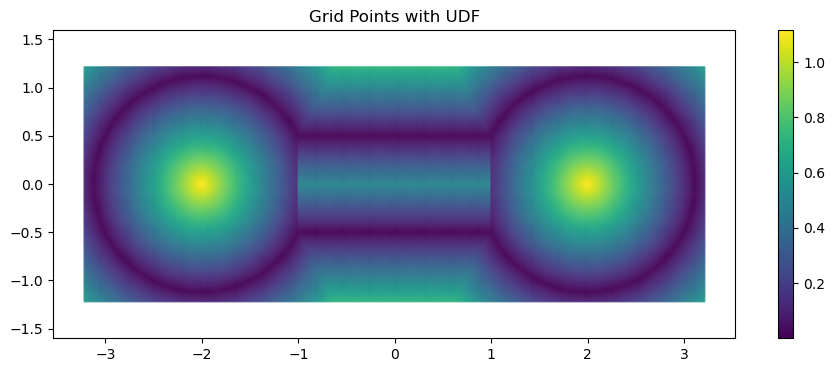

In [7]:
# one example
ds, gp, gd, gs = initiate_dumbbell(2.0, 2.0, 1.0)

## Functions for Training

### Creating Dataset for Dumbbell

In [8]:
def create_dataset_dumbbell(circle_center_x, rec_long_side, rec_short_side, seed, train_percent=0.1, surface_only=False, normalize_features=False, normalize_labels=False):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    ds, gp, gd, gs = initiate_dumbbell(circle_center_x, rec_long_side, rec_short_side, False, False)
    
    sampled_x = ds
    sampled_y = torch.from_numpy(np.zeros((ds.shape[0]))).float()
    if not surface_only:
        sampled_x = gp
        sampled_y = gd
    
    torch.manual_seed(seed)
    (m, n) = sampled_x.shape
    (r, c) = gp.shape
    
    # creating training data
    train_percent = train_percent * (r / m) 
    if train_percent > 1.0:
        train_percent = 1.0
    num_train = int(train_percent*m)
    rand_idx = torch.randperm(m)
    train_idx = rand_idx[:num_train]
    train_x, train_y = sampled_x[train_idx, :], sampled_y[train_idx]
    
    # introducing noise manually
    noise_train_x = 0.0
    train_x += noise_train_x * torch.randn(num_train, n)
    noise_train_y = 0.01
    train_y += noise_train_y * torch.randn(num_train)
    
    # creating test data
    #num_test = m - num_train
    #test_idx = rand_idx[num_train:num_train+num_test]
    test_x, test_y = gp, gd
    
    # introducing noise manually (actually no noise for test data here)
    noise_test_x = 0.0
    test_x += noise_test_x * torch.randn(r, n)
    noise_test_y = 0.0
    test_y += noise_test_y * torch.randn(r)
    
    if normalize_features:
        mu_x, std_x = train_x.mean(dim=-2, keepdim=True), train_x.std(dim=-2, keepdim=True) + 1e-6
        sampled_x.sub_(mu_x).div_(std_x)
        train_x.sub_(mu_x).div_(std_x)
        test_x.sub_(mu_x).div_(std_x)

    if normalize_labels:
        mu_y, std_y = train_y.mean(), train_y.std()
        train_y.sub_(mu_y).div_(std_y)
        test_y.sub_(mu_y).div_(std_y)
        sampled_y.sub_(mu_y).div_(std_y)
        
    sampled_x, sampled_y = sampled_x.contiguous(), sampled_y.contiguous()
    train_x, train_y = train_x.contiguous(), train_y.contiguous()
    test_x, test_y = test_x.contiguous(), test_y.contiguous()
    
    sampled_x, sampled_y = sampled_x.to(device), sampled_y.to(device)
    train_x, train_y = train_x.to(device), train_y.to(device)
    test_x, test_y = test_x.to(device), test_y.to(device)

    if normalize_features:
        mu_x, std_x = mu_x.to(device), std_x.to(device)
        
    with torch.no_grad():
        fig = plt.figure(figsize=(11, 4))
        ax = fig.add_subplot(111)
        plot = ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c=train_y.cpu().numpy())
        fig.colorbar(plot)
        ax.axis('equal')
        ax.set_title(f'Ground Truth Training Data {'(with noise)' if noise_train_x > 0 or noise_train_y > 0 else ''} of {num_train} points')
    
    return train_x, train_y, test_x, test_y, sampled_x, sampled_y
    

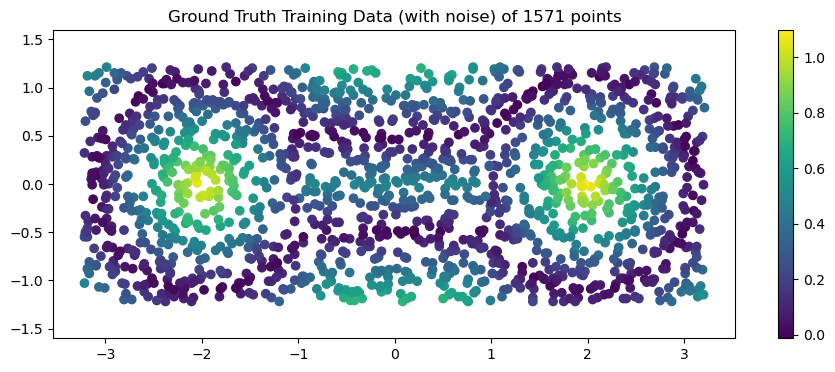

In [9]:
# dataset example
train_x, train_y, test_x, test_y, sampled_x, sampled_y = create_dataset_dumbbell(2.0, 2.0, 1.0, 111, 0.01)

### Kernel Learning Network

In [10]:
class KernelMapper(torch.nn.Sequential):
    def __init__(self, input_data_dim, output_data_dim):
        super(KernelMapper, self).__init__()
        self.add_module('linear1', torch.nn.Linear(input_data_dim, 32))
        self.add_module('relu1', torch.nn.ReLU())
        self.add_module('linear2', torch.nn.Linear(32, 64))
        self.add_module('relu2', torch.nn.ReLU())
        self.add_module('linear3', torch.nn.Linear(64, 128))
        self.add_module('relu3', torch.nn.ReLU())
        self.add_module('linear4', torch.nn.Linear(128, output_data_dim))
        
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood, input_data_dim, kernel_map):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            
            # prior mean and covariance
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=input_data_dim))
            self.kernel_mapper = kernel_map

            # This module will scale the NN features
            self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)

        def forward(self, x):
            # we're first putting our data through an NN
            projected_x = self.kernel_mapper(x)
            projected_x = self.scale_to_bounds(projected_x)
            
            # posterior mean and covariance from Gaussian Process
            mean_x = self.mean_module(projected_x)
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        

### Training and Evaluation

In [11]:
def get_result(train_x, train_y, test_x, test_y, projection_dim, training_iterations, learning_rate=0.001):
    init_input_dim = train_x.size(-1)
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    kernel_map = KernelMapper(init_input_dim, projection_dim)
    model = GPRegressionModel(train_x, train_y, likelihood, projection_dim, kernel_map)

    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()
    
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': model.kernel_mapper.parameters()},
        {'params': model.covar_module.parameters()},
        {'params': model.mean_module.parameters()},
        {'params': model.likelihood.parameters()},
    ], lr=learning_rate)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    iterator = tqdm(range(training_iterations))
    for i in iterator:
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(train_x)
        # Calc loss and backprop derivatives
        loss = -mll(output, train_y)
        loss.backward()
        iterator.set_postfix(loss=loss.item())
        optimizer.step()

    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
        preds = model(test_x)


    print('Test RMSE: {}'.format(torch.sqrt(torch.mean(torch.square(preds.mean - test_y)))))
    
    return model, preds


In [12]:
# training example
model, preds = get_result(train_x, train_y, test_x, test_y, 256, 5)

  0%|          | 0/5 [00:00<?, ?it/s]

Test RMSE: 0.1277819275856018


### Plotting Results

In [13]:
def plot_results(num_train, predictions, test_x, test_y, show_mean=True, show_stdev=True):
    with torch.no_grad():
        if show_mean:
            posterior_mean = predictions.mean.cpu().numpy()
            fig = plt.figure(figsize=(11, 4))
            ax = fig.add_subplot(111)
            plot = ax.scatter(test_x.cpu().numpy()[:, 0], test_x.cpu().numpy()[:, 1], c=posterior_mean)
            #ax.scatter(test_x.cpu().numpy()[:, 0], test_x.cpu().numpy()[:, 1], c='r', s=1.0)
            fig.colorbar(plot)
            ax.axis('equal')
            ax.set_title(f'Posterior Mean (learnt from {num_train} training points)')
        
        if show_stdev:
            posterior_std = predictions.stddev
            fig = plt.figure(figsize=(11, 4))
            ax = fig.add_subplot(111)
            plot = ax.scatter(test_x.cpu().numpy()[:, 0], test_x.cpu().numpy()[:, 1], c = posterior_std.cpu().numpy())
            #ax.scatter(test_x.cpu().numpy()[:, 0], test_x.cpu().numpy()[:, 1], c='r', s=0.5)
            fig.colorbar(plot)
            ax.axis('equal')
            ax.set_title(f'Posterior Standard Deviation (learnt from {num_train} training points)')
    
def plot_on_surface_with_var(num_train, predictions, grid_points, grid_sizes):
    prob_on_surface = norm.pdf(np.zeros(predictions.mean.shape),loc=predictions.mean.cpu(),scale=predictions.stddev.cpu())
    
    gp = grid_points.cpu().numpy()
    gp_x = gp[:, 0].reshape(grid_sizes.cpu().numpy())
    gp_y = gp[:, 1].reshape(grid_sizes.cpu().numpy())
    gp_prob = prob_on_surface.reshape(grid_sizes.cpu().numpy())
    
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.pcolormesh(gp_x, gp_y, gp_prob, shading='gouraud',cmap='viridis')
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title(f'Probability of being on the surface')
    
def plot_result_all(num_train, model, predictions, test_x, test_y, grid_points, grid_sizes, show_mean=True, show_stdev=True):
    plot_results(num_train, predictions, test_x, test_y, show_mean, show_stdev)
    
    with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
        grid_preds = model(grid_points)
    plot_on_surface_with_var(num_train, grid_preds, grid_points, grid_sizes)
    

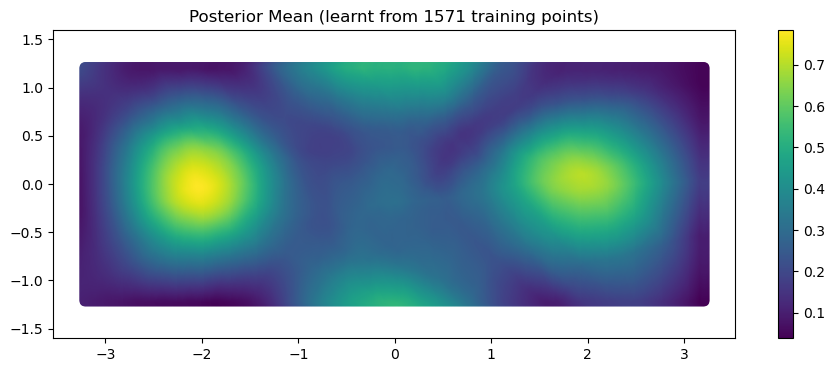

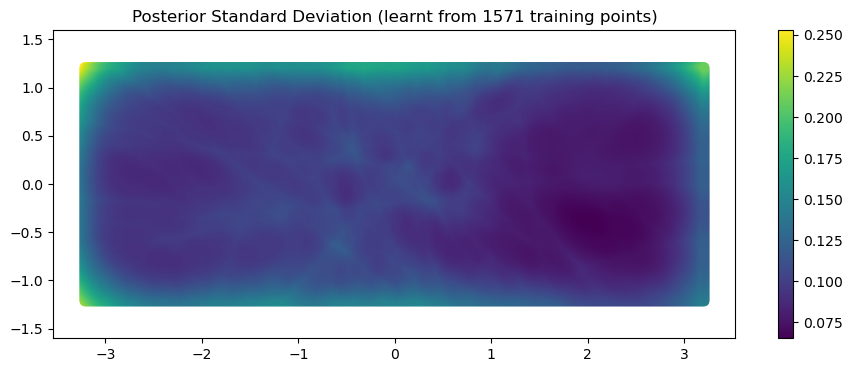

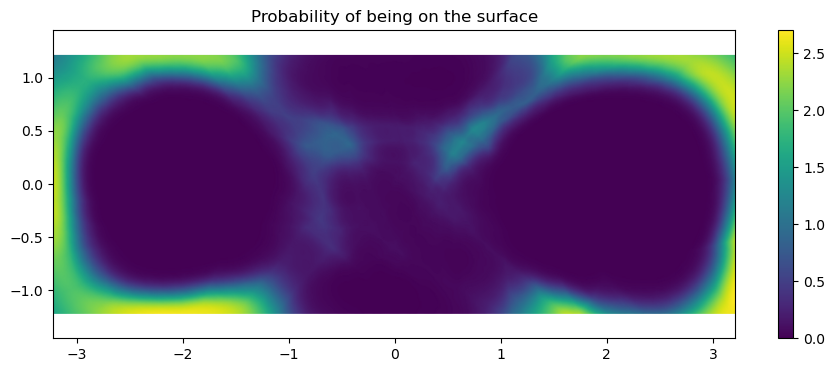

In [14]:
# plot example
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
grid_points = gp.to(device)
grid_sizes = gs.to(device)
num_train = train_x.size(0)
plot_result_all(num_train, model, preds, test_x, test_y, grid_points, grid_sizes)

## Functions for Comparison

In [17]:
def compare_training_percent(list_percent, seed, circle_center_x, rec_long_side, rec_short_side):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    ds, gp, gd, gs = initiate_dumbbell(circle_center_x, rec_long_side, rec_short_side, False, False)
    grid_points = gp.to(device)
    for p in list_percent:
        train_x, train_y, test_x, test_y, sampled_x, sampled_y = create_dataset_dumbbell(circle_center_x, rec_long_side, rec_short_side, seed, p)
        num_train = train_x.size(0)
        model, preds = get_result(train_x, train_y, test_x, test_y, 256, 5)
        plot_result_all(num_train, model, preds, test_x, test_y, grid_points, grid_sizes, False, False)
        
def compare_sampling(seed, circle_center_x, rec_long_side, rec_short_side, training_percent):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    ds, gp, gd, gs = initiate_dumbbell(circle_center_x, rec_long_side, rec_short_side, False, False)
    grid_points = gp.to(device)
    
    train_x, train_y, test_x, test_y, sampled_x, sampled_y = create_dataset_dumbbell(circle_center_x, rec_long_side, rec_short_side, seed, training_percent, True)
    num_train = train_x.size(0)
    model, preds = get_result(train_x, train_y, test_x, test_y, 256, 5)
    plot_result_all(num_train, model, preds, test_x, test_y, grid_points, grid_sizes, False, False)
    
    train_x, train_y, test_x, test_y, sampled_x, sampled_y = create_dataset_dumbbell(circle_center_x, rec_long_side, rec_short_side, seed, training_percent)
    num_train = train_x.size(0)
    model, preds = get_result(train_x, train_y, test_x, test_y, 256, 5)
    plot_result_all(num_train, model, preds, test_x, test_y, grid_points, grid_sizes, False, False)
    

  0%|          | 0/5 [00:00<?, ?it/s]

Test RMSE: 0.13344648480415344


  0%|          | 0/5 [00:00<?, ?it/s]

Test RMSE: 0.11049971729516983


  0%|          | 0/5 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.60 GiB. GPU 

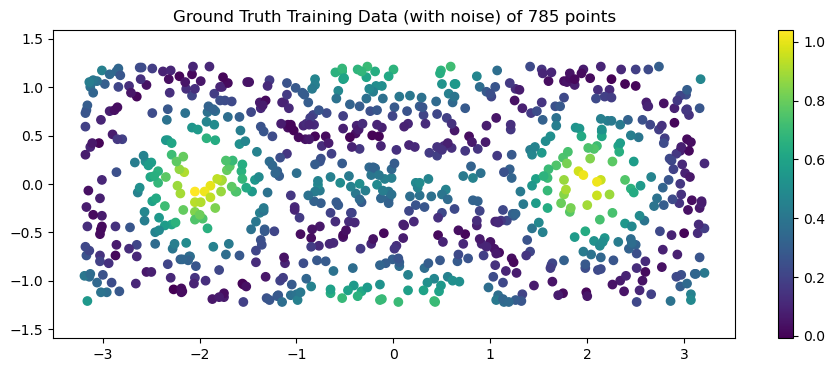

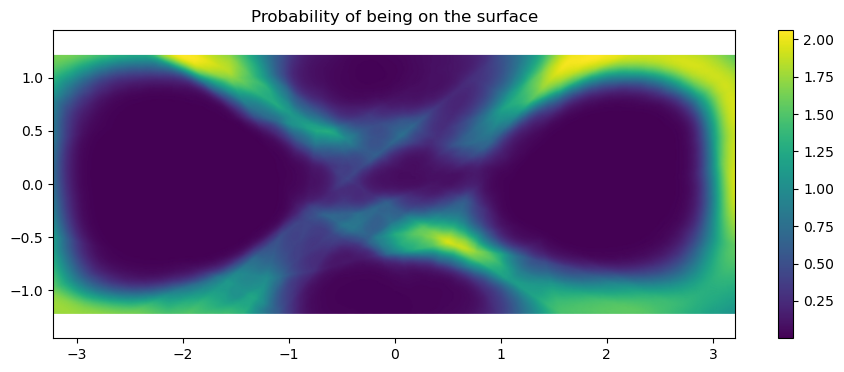

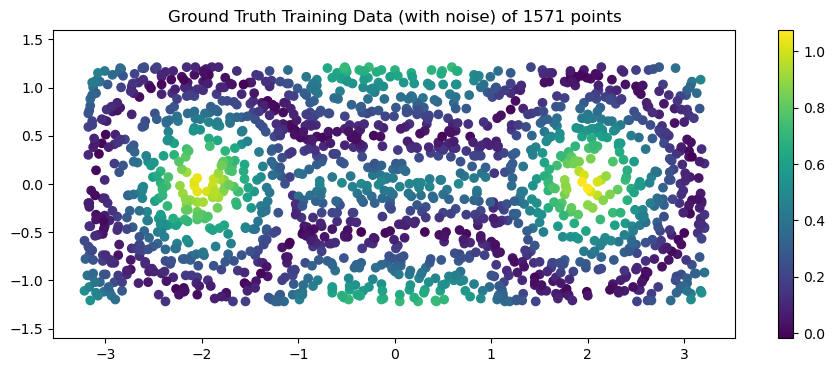

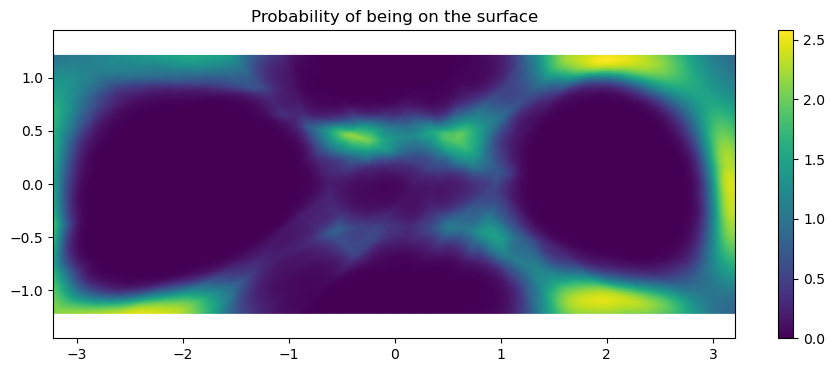

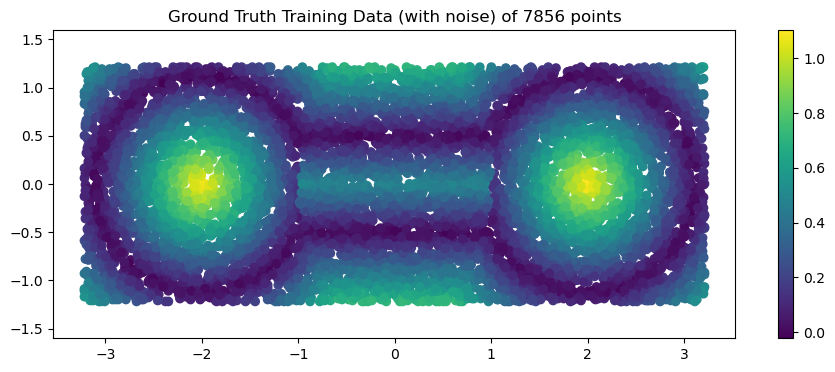

In [18]:
compare_training_percent([0.005, 0.01, 0.05, 0.1], 226, 2.0, 2.0, 1.0)

  0%|          | 0/5 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 942.00 MiB. GPU 

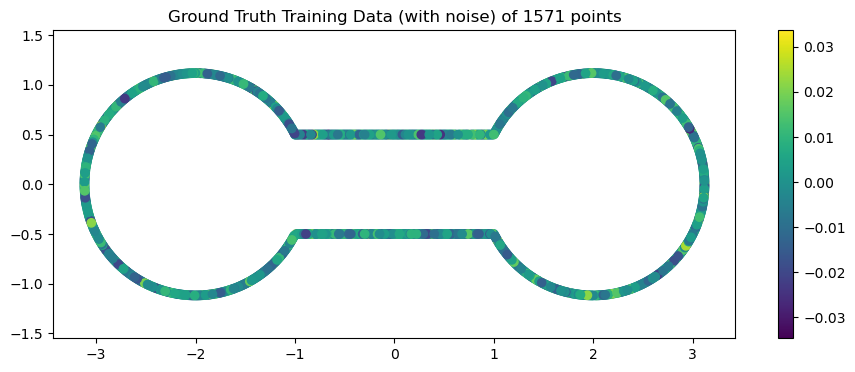

In [20]:
compare_sampling(226, 2.0, 2.0, 1.0, 0.01)